### `03_models_produce_signals.ipynb`

---

## 3.0 Contexto mínimo del notebook

Este notebook entrena un **modelo base** para producir **señales numéricas** sobre la variable objetivo (`calidad`).  
Punto clave: el modelo **no toma decisiones**. Solo entrega outputs cuantitativos que luego se traducen (o no) en acciones mediante reglas operativas externas.

### Recordatorio breve

- El modelo **no decide**.
- El modelo **produce señales numéricas** (scores / probabilidades / predicciones).

### Qué entra en este notebook

- Dataset unificado con variables fisicoquímicas.
- Variable objetivo: `calidad`.
- Variable de contexto: `tipo_vino` (ej. `red`, `white`).

### Qué sale de este notebook

- Un modelo base entrenado (baseline).
- Predicciones crudas:
  - `predict()` (clase / valor estimado)
  - `predict_proba()` (probabilidades, si aplica)
- Señales listas para la siguiente capa:
  - evaluación más rigurosa
  - calibración / umbrales / políticas de decisión (fuera de este notebook)

### Qué NO se hace aquí

- No se definen **umbrales** (thresholds).
- No se aplican **reglas de negocio**.
- No se implementan **acciones** (aprobación, rechazo, revisión humana).
- No se optimiza el modelo (hyperparameter tuning, feature engineering avanzado).
- No se discute “qué decisión es correcta”: este notebook solo entrega señales.

📌 Output de este notebook = **señales**.  
📌 La decisión es un problema **operativo**, no del modelo.

---

## 3.1 Carga y verificación del dataset unificado

En este punto cargamos el **dataset final unificado** (vino tinto + vino blanco) y verificamos que la estructura sea consistente antes de cualquier entrenamiento.

Objetivo:
- Confirmar que las variables numéricas están correctamente cargadas.
- Verificar la presencia de:
  - Variable objetivo: `calidad`.
  - Variable contextual: `tipo_vino`.
- Realizar controles visuales básicos (sanity checks).

No se realiza aún ningún preprocesamiento ni transformación.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

## 3.1 Carga y verificación del dataset unificado

En este punto se cargan los **datasets originales** de vino tinto y vino blanco, se unifican en un solo DataFrame y se guarda el dataset completo en la carpeta `raw` para trazabilidad y reutilización.

Objetivo:
- Trabajar siempre desde las fuentes originales.
- Unificar ambos vinos en un único dataset.
- Dejar persistido el dataset consolidado.

In [2]:
# Rutas a los archivos originales
path_red = "../datasets/raw/winequality-red.csv"
path_white = "../datasets/raw/winequality-white.csv"

# Carga de datos
df_red = pd.read_csv(path_red, sep=";")
df_white = pd.read_csv(path_white, sep=";")

# Etiquetar tipo de vino
df_red["tipo_vino"] = "red"
df_white["tipo_vino"] = "white"

# Unificar en un solo DataFrame
df = pd.concat([df_red, df_white], ignore_index=True)

df.shape

(6497, 13)

In [3]:
# Ruta de salida del dataset unificado
output_path = "../datasets/raw/winequality_unified.csv"

if not os.path.exists(output_path):
    df.to_csv(output_path, index=False)
    print(f"Dataset unificado guardado en: {output_path}")
else:
    print(f"Dataset ya existe, no se volvió a generar: {output_path}")

Dataset ya existe, no se volvió a generar: ../datasets/raw/winequality_unified.csv


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  tipo_vino             6497 non-null   str    
dtypes: float64(11), int64(1), str(1)
memory usage: 660.0 KB


In [5]:
# Renombrar columnas a español

column_mapping = {
    "fixed acidity": "acidez_fija",
    "volatile acidity": "acidez_volatil",
    "citric acid": "acido_citrico",
    "residual sugar": "azucar_residual",
    "chlorides": "cloruros",
    "free sulfur dioxide": "dioxido_azufre_libre",
    "total sulfur dioxide": "dioxido_azufre_total",
    "density": "densidad",
    "pH": "ph",
    "sulphates": "sulfatos",
    "alcohol": "alcohol",
    "quality": "calidad",
    "wine_type": "tipo_vino",
}

df = df.rename(columns=column_mapping)

In [6]:
df.head()

,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,ph,sulfatos,alcohol,calidad,tipo_vino
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [7]:
df.columns.tolist()

['acidez_fija',
 'acidez_volatil',
 'acido_citrico',
 'azucar_residual',
 'cloruros',
 'dioxido_azufre_libre',
 'dioxido_azufre_total',
 'densidad',
 'ph',
 'sulfatos',
 'alcohol',
 'calidad',
 'tipo_vino']

In [8]:
df.dtypes

acidez_fija             float64
acidez_volatil          float64
acido_citrico           float64
azucar_residual         float64
cloruros                float64
dioxido_azufre_libre    float64
dioxido_azufre_total    float64
densidad                float64
ph                      float64
sulfatos                float64
alcohol                 float64
calidad                   int64
tipo_vino                   str
dtype: object

In [9]:
required_columns = ["calidad", "tipo_vino"]

missing = [col for col in required_columns if col not in df.columns]
missing

[]

Resultado de la verificación:

- El dataset contiene **13 columnas**, todas correctamente definidas.
- Las variables fisicoquímicas están en formato **numérico (`float64`)**.
- La variable objetivo `calidad` está en formato **entero (`int64`)**.
- La variable contextual `tipo_vino` está correctamente definida como **categórica**.
- No se detectan columnas faltantes en las variables críticas.

El dataset es consistente desde el punto de vista estructural y está listo para el análisis de distribuciones previo al entrenamiento.

---
---
---

## 3.2 Análisis rápido de distribuciones (control visual)

Antes de entrenar cualquier modelo, realizamos un **control visual mínimo** sobre algunas variables clave del dataset.

Objetivo:
- Confirmar que las distribuciones son razonables.
- Detectar anomalías evidentes (valores imposibles, errores de carga).
- Verificar diferencias esperables entre tipos de vino.

Este análisis **no es exploratorio ni conclusivo**.  
No se toman decisiones de modelado en este punto.

In [10]:
import matplotlib.pyplot as plt

### 📊 Celda de código — Histograma de calidad

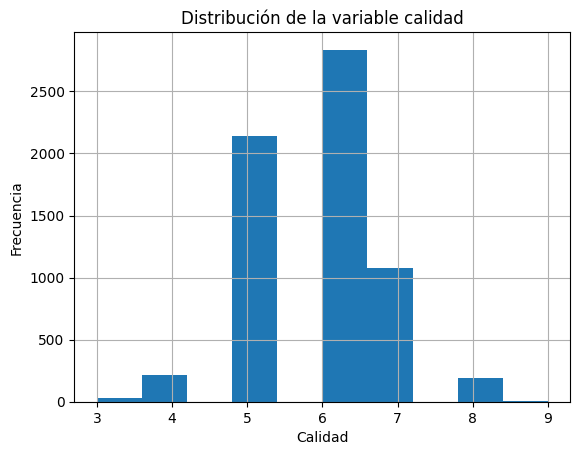

In [11]:
df["calidad"].hist(bins=10)
plt.title("Distribución de la variable calidad")
plt.xlabel("Calidad")
plt.ylabel("Frecuencia")
plt.show()

> La distribución de la variable `calidad` muestra una concentración clara en valores intermedios (principalmente entre 5 y 7), lo cual es consistente con
> evaluaciones humanas de calidad.
> Los valores extremos son poco frecuentes, y en particular las valoraciones más altas (por ejemplo, 9) aparecen únicamente en vinos blancos, lo que refleja diferencias reales entre subgrupos y confirma que el dataset conserva variabilidad estructural sin estar artificialmente recortado.

### 📊 Celda de código — Histograma de alcohol

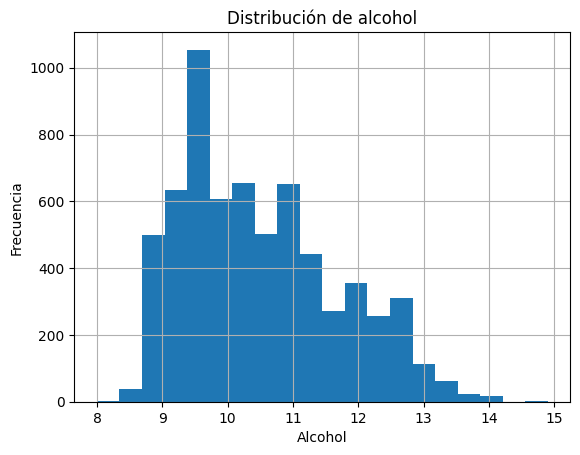

In [12]:
df["alcohol"].hist(bins=20)
plt.title("Distribución de alcohol")
plt.xlabel("Alcohol")
plt.ylabel("Frecuencia")
plt.show()

> La distribución de la variable `alcohol` muestra una mayor concentración de observaciones en rangos medios, con una disminución progresiva de frecuencia a medida que aumentan los valores.
> Se observa una cola hacia valores altos de alcohol, con pocos registros en los extremos superiores.

### 📊 Celda de código — Boxplot de sulfatos por tipo de vino

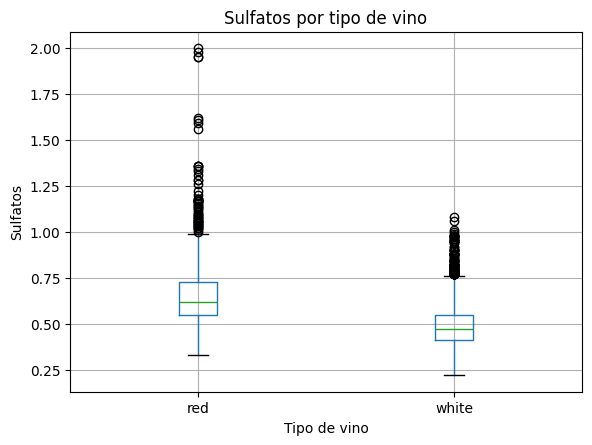

In [13]:
df.boxplot(column="sulfatos", by="tipo_vino")
plt.title("Sulfatos por tipo de vino")
plt.suptitle("")
plt.xlabel("Tipo de vino")
plt.ylabel("Sulfatos")
plt.show()

> El boxplot de `sulfatos` por `tipo_vino` muestra diferencias claras en la distribución entre vinos tintos y blancos.
> Los vinos tintos presentan valores centrales más altos y una mayor dispersión, mientras que los vinos blancos concentran valores más bajos con menor variabilidad.


---
---
---

## 3.3 Definición explícita de X e y

En este punto se definen de forma explícita las variables de entrada (`X`) y la variable objetivo (`y`) que se utilizarán para el entrenamiento del modelo.

### Decisión tomada

- `X`: todas las variables físico-químicas del vino + la variable contextual `tipo_vino`.
- `y`: `calidad`, tratada como **variable multiclase**.

No se binariza la variable objetivo en este notebook.

### Justificación operativa

- El objetivo es producir **señales ricas**, no decisiones finales.
- La variable `calidad` es ordinal y discreta, y su estructura multiclase contiene más información que una versión binaria.
- La binarización, si fuese necesaria, se considera una **decisión posterior**, dependiente del contexto operativo.

Esta decisión es intencional y no se revisa en este punto.

### 🧠 Celda de código — Definición de X e y

In [14]:
# Variable objetivo
y = df["calidad"]

# Variables de entrada
X = df.drop(columns=["calidad"])

### 🧠 Celda de código — Verificación rápida de shapes

In [15]:
X.shape, y.shape

((6497, 12), (6497,))

### 🧠 Celda de código — Verificación de tipos en X

In [16]:
X.dtypes

acidez_fija             float64
acidez_volatil          float64
acido_citrico           float64
azucar_residual         float64
cloruros                float64
dioxido_azufre_libre    float64
dioxido_azufre_total    float64
densidad                float64
ph                      float64
sulfatos                float64
alcohol                 float64
tipo_vino                   str
dtype: object

Resultado:

- `X` y `y` quedaron definidos de forma clara y reproducible.
- La variable objetivo se mantiene en formato multiclase.
- No se aplicó aún ningún tipo de codificación ni escalado.

En el siguiente punto se realiza el preprocesamiento mínimo y la preparación del pipeline antes del split.

---
---
---

## 3.4 Codificación y preprocesamiento mínimo

En este punto se aplica el **preprocesamiento estrictamente necesario** para poder entrenar el modelo base.

Decisiones tomadas:
- La variable `tipo_vino` se codifica de forma explícita.
- Las variables numéricas se escalan.
- Todo el preprocesamiento se encapsula en un **pipeline reproducible**.

No se realiza feature engineering avanzado ni selección de variables.

### 🧠 Celda de código — Imports de preprocesamiento

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### 🧠 Celda de código — Identificación de tipos de variables

In [18]:
# Variable categórica
categorical_features = ["tipo_vino"]

# Variables numéricas
numerical_features = X.columns.drop("tipo_vino").tolist()

In [19]:
categorical_features

['tipo_vino']

In [20]:
numerical_features

['acidez_fija',
 'acidez_volatil',
 'acido_citrico',
 'azucar_residual',
 'cloruros',
 'dioxido_azufre_libre',
 'dioxido_azufre_total',
 'densidad',
 'ph',
 'sulfatos',
 'alcohol']

En este bloque se separan explícitamente las variables según su tipo.

- `categorical_features` identifica la variable categórica (`tipo_vino`).
- `numerical_features` agrupa todas las variables físico-químicas, excluyendo `tipo_vino`.

Esta separación permite aplicar transformaciones específicas a cada tipo de variable en el pipeline de preprocesamiento.

### 🧠 Celda de código — Definición del preprocesamiento

In [21]:
# Preprocesamiento para variables categóricas
categorical_transformer = OneHotEncoder(drop="first")

# Preprocesamiento para variables numéricas
numerical_transformer = StandardScaler()

En este bloque se definen las transformaciones que se aplicarán a cada tipo de variable.

- `OneHotEncoder(drop="first")` convierte la variable categórica `tipo_vino` en una representación binaria, eliminando una categoría para evitar redundancia.
- `StandardScaler()` estandariza las variables numéricas, llevándolas a una escala común con media cero y desviación estándar uno.

Estas transformaciones preparan los datos para el entrenamiento del modelo sin introducir complejidad innecesaria.

### 🧠 Celda de código — ColumnTransformer

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

En este bloque se construye el objeto `ColumnTransformer`, que permite aplicar distintas transformaciones a diferentes grupos de columnas.

- A las variables numéricas se les aplica el escalado definido en `numerical_transformer`.
- A la variable categórica `tipo_vino` se le aplica la codificación definida en `categorical_transformer`.

El resultado es un preprocesamiento unificado y reproducible que transforma cada columna según su naturaleza.

### 🧠 Celda de código — Pipeline mínimo (sin modelo aún)

In [23]:
pipeline_preprocessing = Pipeline(
    steps=[
        ("preprocessing", preprocessor)
    ]
)

pipeline_preprocessing

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse m

En este bloque se encapsula todo el preprocesamiento dentro de un objeto `Pipeline`.

- El paso `preprocessing` aplica el `ColumnTransformer` definido previamente.
- El pipeline garantiza que las transformaciones se ejecuten siempre en el mismo orden y de forma consistente.

El resultado es un componente reutilizable que puede integrarse directamente con el modelo en el siguiente paso.

### 📘 Celda Markdown — Cierre del punto 3.4

Resultado:

- `tipo_vino` queda correctamente codificado.
- Las variables numéricas quedan escaladas.
- El preprocesamiento es explícito, reproducible y controlado.
- El pipeline está listo para integrarse con el modelo.

En el siguiente punto se realiza el split del dataset en entrenamiento, validación y prueba.

---
---
---

## 3.5 Split del dataset (train / validation / test)

En este punto se divide el dataset en tres subconjuntos con roles claramente diferenciados:

- **Train**: datos utilizados para entrenar el modelo.
- **Validation / calibration**: datos utilizados para ajustar y calibrar las probabilidades del modelo.
- **Test**: datos reservados exclusivamente para la evaluación final.

La división se realiza de forma **estratificada**, preservando la distribución de:
- `tipo_vino`
- `calidad`

Este paso es un **control operativo crítico** para evitar sesgos y métricas engañosas.

### 🧠 Celda de código — Imports para el split

In [24]:
from sklearn.model_selection import train_test_split

### 🧠 Celda de código — Preparación para estratificación conjunta

In [25]:
# Variable auxiliar para estratificación conjunta
stratify_col = df["tipo_vino"].astype(str) + "_" + df["calidad"].astype(str)

stratify_col.value_counts().head()

white_6    2198
white_5    1457
white_7     880
red_5       681
red_6       638
Name: count, dtype: int64

En este bloque se crea una **variable auxiliar de estratificación** combinando `tipo_vino` y `calidad`.

Las etiquetas como `white_6`, `red_5`, etc. representan **combinaciones específicas de tipo de vino y nivel de calidad**.

- La parte textual (`white` o `red`) indica el **tipo de vino**.
- La cifra numérica corresponde al **valor de la variable `calidad`** asignado a ese vino.

Por ejemplo:
- `white_6` → vino blanco con calidad 6.
- `red_5` → vino tinto con calidad 5.

Estas combinaciones permiten tratar cada par *(tipo de vino, calidad)* como un grupo independiente durante la estratificación, asegurando que todos ellos queden correctamente representados en los distintos subconjuntos del dataset.

El conteo mostrado confirma cuántos registros existen por cada combinación, y sirve como control previo para asegurar que todos los grupos relevantes estén representados en los conjuntos de entrenamiento, validación y prueba.

### 🧠 Celda de código — Primer split: train vs temp

In [26]:
X_train, X_temp, y_train, y_temp, strat_train, strat_temp = train_test_split(
    X,
    y,
    stratify_col,
    test_size=0.30,
    random_state=42,
    stratify=stratify_col
)

X_train.shape, X_temp.shape

((4547, 12), (1950, 12))

En este bloque se realiza el **primer split del dataset**.

- `X` y `y` se dividen en:
  - `X_train`, `y_train`: conjunto de entrenamiento.
  - `X_temp`, `y_temp`: conjunto temporal que se dividirá luego en validación y test.
- `stratify_col` se utiliza para que la división preserve la distribución conjunta de `tipo_vino` y `calidad`.
- `test_size=0.30` reserva el 30 % de los datos para validación y prueba.
- `random_state=42` garantiza reproducibilidad.

El resultado (`shape`) confirma el tamaño relativo de los conjuntos de entrenamiento y del conjunto temporal.

`- - -`

`strat_train` y `strat_temp` son las versiones divididas de la variable auxiliar `stratify_col`.

- `strat_train` contiene las etiquetas de estratificación correspondientes a los registros que quedaron en **train**.
- `strat_temp` contiene las etiquetas de estratificación de los registros que quedaron en el conjunto **temporal**.

Estas variables **no se usan para entrenar el modelo**.  
Su único propósito es permitir una **segunda estratificación correcta** al dividir el conjunto temporal en validación y test, manteniendo la misma estructura de `tipo_vino` y `calidad`.

### 🧠 Celda de código — Segundo split: validation vs test

In [27]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=strat_temp
)

X_val.shape, X_test.shape

((975, 12), (975, 12))

En este bloque se realiza el **segundo split**, a partir del conjunto temporal (`X_temp`, `y_temp`).

- El conjunto temporal se divide en dos partes iguales:
  - **Validation** (`X_val`, `y_val`)
  - **Test** (`X_test`, `y_test`)
- `test_size=0.50` indica que cada subconjunto recibe el 50 % del conjunto temporal.
- Se utiliza `stratify=strat_temp` para preservar, nuevamente, la distribución conjunta de `tipo_vino` y `calidad`.
- `random_state=42` asegura que la división sea reproducible.

El resultado (`shape`) confirma que los conjuntos de validación y prueba tienen el mismo tamaño y mantienen la misma estructura estadística que el dataset original.

### 📊 Celda de código — Visualización: distribución de `calidad`

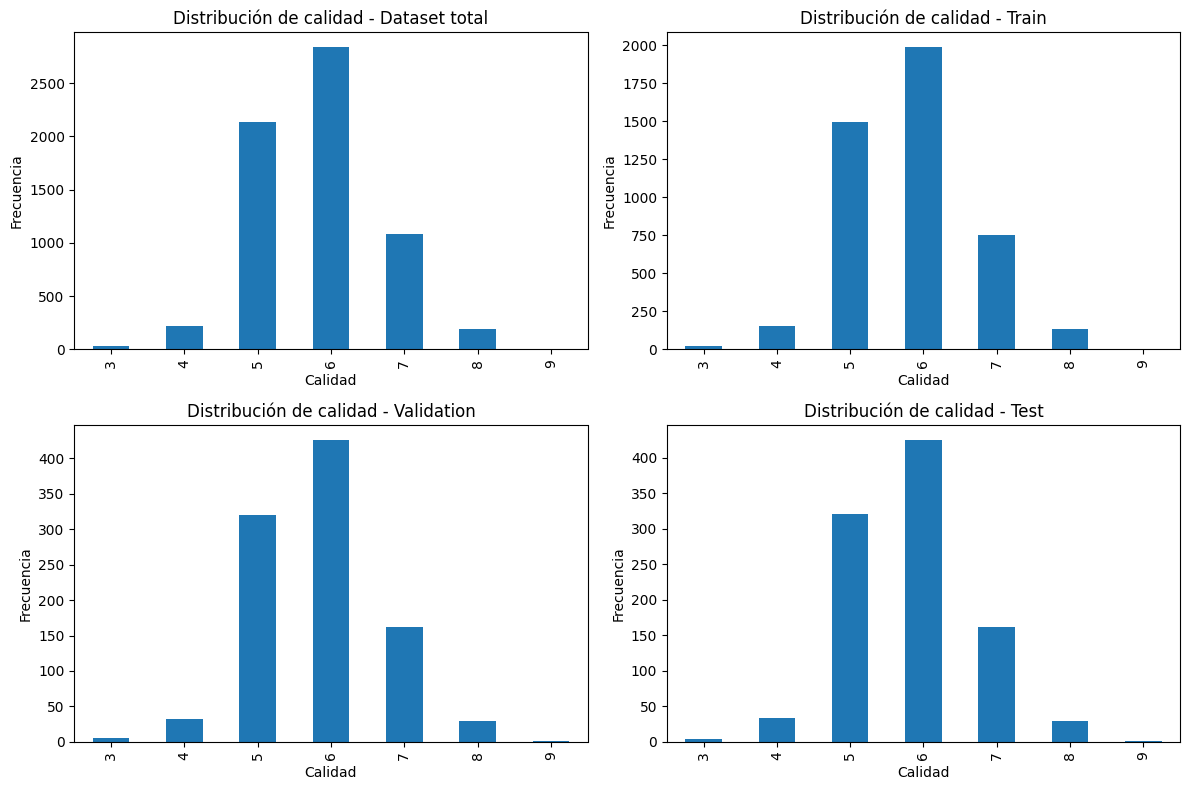

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

datasets = [
    (y, "Distribución de calidad - Dataset total"),
    (y_train, "Distribución de calidad - Train"),
    (y_val, "Distribución de calidad - Validation"),
    (y_test, "Distribución de calidad - Test"),
]

for ax, (data, title) in zip(axes, datasets):
    data.value_counts().sort_index().plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Calidad")
    ax.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Conclusión operativa:

- El dataset fue dividido en tres subconjuntos con roles claros.
- La estratificación preserva la estructura original por `tipo_vino` y `calidad`.
- Las distribuciones de la variable objetivo se mantienen consistentes entre splits.
- El modelo puede entrenarse y evaluarse sin introducir sesgos por muestreo.

El siguiente paso es entrenar el modelo base utilizando exclusivamente el conjunto de entrenamiento.

---
---
---

## 3.6 Entrenamiento del modelo base

En este punto se entrena un **modelo base multiclase** para predecir `calidad`.

Decisión tomada:
- Modelo: **Logistic Regression (multinomial / softmax)**.
- Entrenamiento: exclusivamente con el conjunto **train**.
- Preprocesamiento: se usa el pipeline definido en 3.4 para garantizar consistencia.

📌 El modelo aprende patrones estadísticos. No define políticas ni decisiones operativas.

### 🧠 Celda de código — Imports del modelo

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

### 🧠 Celda de código — Definir modelo (softmax) + pipeline completo

In [30]:
# Modelo base multiclase (softmax implícito)
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=2000
)

# Pipeline completo: preprocesamiento + modelo
model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", clf)
    ]
)

model

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

Este código define el **modelo base completo** que se usará en el notebook.

- Se crea un modelo de **Regresión Logística multiclase**, que aprenderá a predecir la variable `calidad`.
- El preprocesamiento (codificación y escalado) se integra directamente con el modelo mediante un `Pipeline`.
- El pipeline garantiza que los datos se transformen y se entrenen de forma consistente en un solo flujo.

El resultado es un sistema end-to-end que recibe datos crudos y produce señales numéricas.

### 🧠 Celda de código — Entrenamiento solo con train

In [31]:
model.fit(X_train, y_train)

"Modelo entrenado"

'Modelo entrenado'

### 🧠 Celda de código — Verificación mínima post-entrenamiento

In [32]:
model.named_steps["model"].classes_

array([3, 4, 5, 6, 7, 8, 9])

En este bloque se entrena el modelo utilizando **exclusivamente el conjunto de entrenamiento** (`X_train`, `y_train`).

- `model.fit(X_train, y_train)` ejecuta todo el pipeline:
  - aplica el preprocesamiento,
  - ajusta el modelo a los datos.
- El mensaje `"Modelo entrenado"` confirma que el proceso finalizó correctamente.

Al consultar `model.named_steps["model"].classes_`, se observan las clases que el modelo aprendió a predecir.

El resultado indica que el modelo fue entrenado en un **escenario multiclase**, con niveles de calidad entre 3 y 9.

---
---
---

## 3.7 Outputs del modelo: señales crudas

En este punto se inspeccionan los **outputs directos del modelo**.

Objetivo:
- Observar qué produce el modelo una vez entrenado.
- Diferenciar entre:
  - la clase predicha (`predict`)
  - las probabilidades asociadas a cada clase (`predict_proba`)

Estos outputs son **señales crudas**.  
No implican decisiones ni acciones.

### 🧠 Celda de código — Predicciones básicas

In [33]:
# Predicción de clases
y_pred = model.predict(X_test)

# Predicción de probabilidades
y_proba = model.predict_proba(X_test)

y_pred[:5]

array([5, 6, 5, 6, 6])

In [34]:
y_proba[:5]

array([[3.65942641e-03, 7.28744410e-02, 6.09872598e-01, 2.92554491e-01,
        1.97438489e-02, 1.26494063e-03, 3.02532733e-05],
       [6.48842589e-03, 2.41289333e-02, 1.06029878e-01, 5.16179266e-01,
        2.84489502e-01, 5.54366417e-02, 7.24735260e-03],
       [3.37869851e-03, 2.50375303e-01, 5.41916248e-01, 1.86403012e-01,
        1.65238733e-02, 1.34611082e-03, 5.67552947e-05],
       [2.68262085e-03, 1.17828186e-02, 1.17451294e-01, 5.47347015e-01,
        2.79669038e-01, 4.02935157e-02, 7.73697096e-04],
       [2.96092262e-04, 2.02507598e-02, 1.11538520e-01, 5.51046999e-01,
        2.83224397e-01, 3.33611996e-02, 2.82032057e-04]])

En este bloque se generan y se inspeccionan las **señales crudas** producidas por el modelo entrenado.

### `predict()`
- `model.predict(X_test)` devuelve, para cada registro, la **clase con mayor probabilidad**.
- El resultado `array([5, 6, 5, 6, 6])` indica que, para las primeras cinco observaciones del conjunto de test, el modelo predice niveles de calidad 5 o 6.
- Esta salida es una **decisión implícita del modelo** (la clase más probable), pero aún no es una decisión operativa.

### `predict_proba()`
- `model.predict_proba(X_test)` devuelve, para cada registro, la **distribución completa de probabilidades** sobre todas las clases aprendidas.
- Cada fila del array corresponde a una observación.
- Cada columna corresponde a una clase de `calidad` (en el orden `[3, 4, 5, 6, 7, 8, 9]`).

Por ejemplo, en la primera fila:
- La mayor probabilidad está asociada a la clase `5`.
- Otras clases mantienen probabilidades menores, lo que refleja **incertidumbre residual** del modelo.

### Lectura clave
- `predict()` responde: *“¿cuál es la clase más probable?”*
- `predict_proba()` responde: *“¿qué tan probable es cada clase?”*

Estas probabilidades son la **señal fundamental** que se utilizará más adelante para calibración, umbrales y decisiones bajo incertidumbre.

### 🧠 Celda de código — Inspección fila a fila

In [35]:
# Crear un DataFrame de inspección
inspection_df = X_test.copy()
inspection_df["calidad_real"] = y_test.values
inspection_df["calidad_predicha"] = y_pred

inspection_df.head()

,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,ph,sulfatos,alcohol,tipo_vino,calidad_real,calidad_predicha
847,7.4,0.68,0.16,1.8,0.078,12.0,39.0,0.99770,3.50,0.70,9.9,red,6,5
3340,7.7,0.38,0.40,2.0,0.038,28.0,152.0,0.99060,3.18,0.32,12.9,white,6,6
4331,7.9,0.51,0.34,2.6,0.049,13.0,135.0,0.99335,3.09,0.51,10.0,white,5,5
5713,7.5,0.21,0.29,1.5,0.046,35.0,107.0,0.99123,3.15,0.45,11.3,white,6,6
4959,7.1,0.18,0.49,1.3,0.033,12.0,72.0,0.99072,3.05,0.53,11.3,white,7,6


Este bloque construye una **tabla de inspección** que permite analizar las predicciones del modelo a nivel de observación individual.

- Se copian las variables originales del conjunto de test (`X_test`).
- Se añade la **calidad real** (`calidad_real`) proveniente de `y_test`.
- Se añade la **calidad predicha** por el modelo (`calidad_predicha`).

El resultado es un DataFrame que permite comparar, fila a fila:
- las características del vino,
- el valor real de calidad,
- y la predicción del modelo.

Esta vista es clave para entender **dónde acierta y dónde se equivoca** el modelo, sin aplicar aún métricas agregadas ni decisiones operativas.

### 🧠 Celda de código — Añadir probabilidades por clase (primeras filas)

In [36]:
proba_df = pd.DataFrame(
    y_proba,
    columns=[f"proba_clase_{c}" for c in model.named_steps["model"].classes_],
    index=inspection_df.index
)

inspection_with_proba = pd.concat([inspection_df, proba_df], axis=1)

inspection_with_proba.head()

,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,ph,sulfatos,...,tipo_vino,calidad_real,calidad_predicha,proba_clase_3,proba_clase_4,proba_clase_5,proba_clase_6,proba_clase_7,proba_clase_8,proba_clase_9
847,7.4,0.68,0.16,1.8,0.078,12.0,39.0,0.99770,3.50,0.70,...,red,6,5,0.003659,0.072874,0.609873,0.292554,0.019744,0.001265,0.000030
3340,7.7,0.38,0.40,2.0,0.038,28.0,152.0,0.99060,3.18,0.32,...,white,6,6,0.006488,0.024129,0.106030,0.516179,0.284490,0.055437,0.007247
4331,7.9,0.51,0.34,2.6,0.049,13.0,135.0,0.99335,3.09,0.51,...,white,5,5,0.003379,0.250375,0.541916,0.186403,0.016524,0.001346,0.000057
5713,7.5,0.21,0.29,1.5,0.046,35.0,107.0,0.99123,3.15,0.45,...,white,6,6,0.002683,0.011783,0.117451,0.547347,0.279669,0.040294,0.000774
4959,7.1,0.18,0.49,1.3,0.033,12.0,72.0,0.99072,3.05,0.53,...,white,7,6,0.000296,0.020251,0.111539,0.551047,0.283224,0.033361,0.000282


En este bloque se amplía la tabla de inspección incorporando las **probabilidades por clase** generadas por el modelo.

- `proba_df` transforma el array de `predict_proba()` en un DataFrame legible:
  - cada columna (`proba_clase_X`) representa la probabilidad asignada a una clase de `calidad`.
- El índice se alinea con `inspection_df` para mantener correspondencia fila a fila.
- `pd.concat` une las variables originales, la calidad real, la calidad predicha y las probabilidades en una sola tabla.

El resultado es una vista completa que permite analizar no solo **qué clase predice el modelo**, sino **con qué nivel de confianza lo hace para cada alternativa**.

### 📊 Celda de código — Distribución de probabilidades máximas

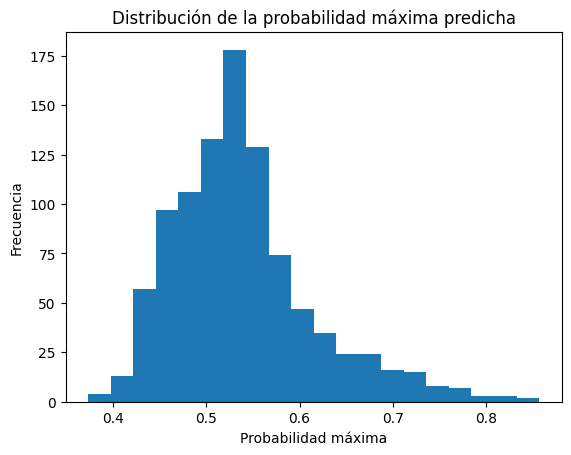

In [37]:
max_proba = y_proba.max(axis=1)

plt.hist(max_proba, bins=20)
plt.title("Distribución de la probabilidad máxima predicha")
plt.xlabel("Probabilidad máxima")
plt.ylabel("Frecuencia")
plt.show()

> La distribución de la **probabilidad máxima predicha** muestra que la mayoría de las observaciones se concentran en valores intermedios, alrededor de 0.5–0.6.
> Se observa una cola hacia probabilidades más altas, con pocos casos donde el modelo asigna una probabilidad máxima cercana a 0.8 o superior.

### 🧠 Celda de código — Score vs probabilidad (si aplica)

In [38]:
# Scores (logits) internos del modelo
scores = model.named_steps["model"].decision_function(
    model.named_steps["preprocessing"].transform(X_test)
)

scores[:5]

array([[-1.18807383,  1.80335773,  3.92786984,  3.1932707 ,  0.49746175,
        -2.25035505, -5.98353114],
       [-2.07429148, -0.76089976,  0.71940949,  2.30214268,  1.70638492,
         0.07092934, -1.96367519],
       [-1.42486564,  2.88060478,  3.65275525,  2.58555484,  0.16244998,
        -2.34513666, -5.51136255],
       [-2.38431518, -0.90446701,  1.3949143 ,  2.93397357,  2.26249747,
         0.32508112, -3.62768426],
       [-4.17496943,  0.05030706,  1.75648475,  3.35393485,  2.68835426,
         0.54950829, -4.22361979]])

Este bloque extrae los **scores internos (logits)** del modelo para cada clase de `calidad`.

### Qué hace el código
- `model.named_steps["preprocessing"].transform(X_test)` aplica el mismo preprocesamiento del pipeline (scaling + encoding) sobre `X_test`.
- `model.named_steps["model"].decision_function(...)` calcula, para cada observación, un **score por cada clase** antes de convertirlos a probabilidades.

### Qué son los resultados
- El resultado es una matriz donde:
  - cada **fila** = una observación del conjunto de test
  - cada **columna** = el score asociado a una clase (en el orden de `model.named_steps["model"].classes_`, por ejemplo `[3, 4, 5, 6, 7, 8, 9]`).
- Los valores pueden ser positivos o negativos porque **no son probabilidades**, son scores en escala logit.
- La clase con el **score más alto** en una fila es la que el modelo tiende a predecir (equivale a la clase más probable tras aplicar softmax).

En resumen: esto muestra la señal “cruda” previa a `predict_proba()`.

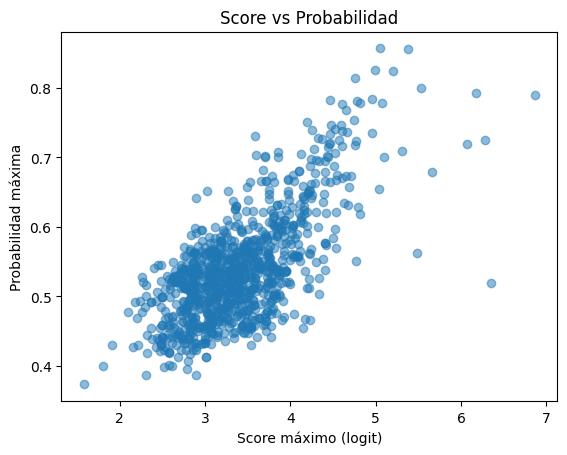

In [39]:
plt.scatter(scores.max(axis=1), max_proba, alpha=0.5)
plt.xlabel("Score máximo (logit)")
plt.ylabel("Probabilidad máxima")
plt.title("Score vs Probabilidad")
plt.show()

> El gráfico muestra la relación entre el **score máximo (logit)** y la **probabilidad máxima** asignada por el modelo para cada observación.
> Se observa una relación creciente: a mayor score, mayor probabilidad asociada.
> La dispersión indica que distintos scores pueden mapearse a probabilidades similares, lo que refleja cómo el modelo transforma señales internas en probabilidades mediante la función softmax.